# Juan Felipe Osorio Franco


# Ejercicio

- Realice una comparación de los métodos de clustering vistos, para generar una segmentación de imagen a color, incluyendo la información de ubicación de cada pixel.

- Consulte en qué consiste el algoritmo PCA y [UMAP](https://umap-learn.readthedocs.io/en/latest/). Ver guía [Reducción de dimensión](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/8_ReduccionDimension.ipynb)

- Repita el punto anterior realizando una proyección 2D de los datos con PCA y UMAP antes de generar las segmentaciones.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import umap
from skimage import data
from skimage.transform import resize

In [52]:

# Funciones para aplicar clustering y visualizar resultados
def apply_kmeans_clustering(X, n_clusters=5):
    # Aplica clustering K-means a los datos de entrada
    kmeans = KMeans(n_clusters=n_clusters)
    return kmeans.fit_predict(X)

def apply_dbscan_clustering(X, eps=5, min_samples=5):
    # Aplica clustering DBSCAN a los datos de entrada
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    return dbscan.fit_predict(X)

def plot_segmented_image(labels, image_shape, title):
    # Visualiza la imagen segmentada según las etiquetas del clustering
    h, w = image_shape[:2]
    unique_labels = np.unique(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    segmented_image = np.zeros((h * w, 3), dtype=np.uint8)

    for k, col in zip(unique_labels, colors):
        if k == -1:  # Puntos de ruido en DBSCAN
            col = [0, 0, 0]
        else:
            col = (col[:3] * 255).astype(int)
        class_member_mask = (labels == k)
        segmented_image[class_member_mask] = col

    segmented_image = segmented_image.reshape(h, w, 3)

    plt.figure(figsize=(6, 6))
    plt.imshow(segmented_image)
    plt.axis('off')
    plt.title(title)
    plt.show()


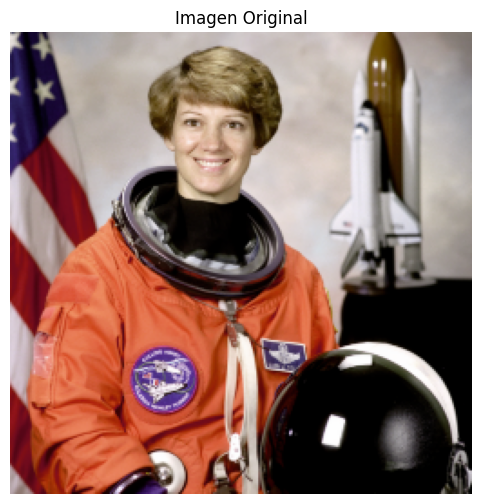

In [53]:
# Carga y preprocesamiento de la imagen
image = data.astronaut()
image = resize(image, (255, 255), anti_aliasing=True, preserve_range=True).astype(np.uint8)
h, w, c = image.shape

# Preparación de los datos
pixels = image.reshape(-1, 3)
x_coords = np.repeat(np.arange(h), w)
y_coords = np.tile(np.arange(w), h)
X = np.column_stack((pixels, x_coords, y_coords))

# Visualización de la imagen original
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.title('Imagen Original')
plt.show()


Aplicando clustering a datos originales...


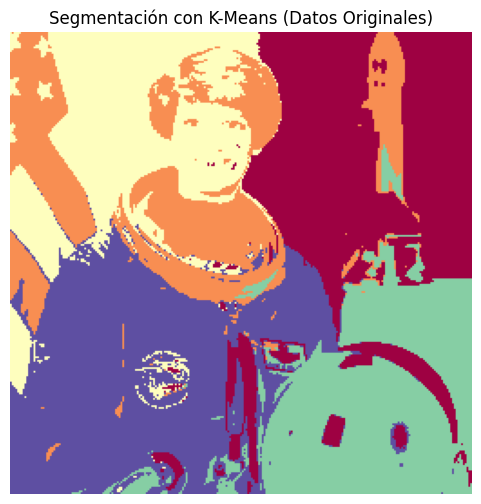

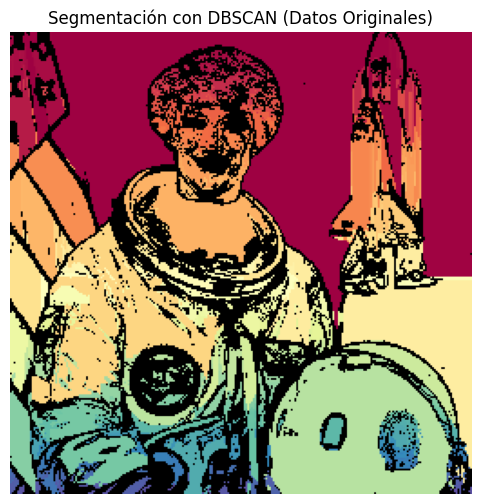

In [54]:

# Aplicación de clustering a los datos originales
print("Aplicando clustering a datos originales...")
labels_kmeans = apply_kmeans_clustering(X)
plot_segmented_image(labels_kmeans, image.shape, 'Segmentación con K-Means (Datos Originales)')

labels_dbscan = apply_dbscan_clustering(X)
plot_segmented_image(labels_dbscan, image.shape, 'Segmentación con DBSCAN (Datos Originales)')


# Reducción de Dimensionalidad con PCA y UMAP
## Principal Component Analysis (PCA)

PCA es un método de reducción de dimensionalidad lineal que busca encontrar una nueva base de coordenadas para los datos donde las direcciones de máxima varianza estén decorrelacionadas. Los pasos principales del algoritmo se pueden describir mediante las siguientes fórmulas:

1. **Cálculo de la matriz de covarianza**: Se calcula la matriz de covarianza \( \mathbf{C} \) de los datos \( \mathbf{X} \):

$$
\mathbf{C} = \frac{1}{n} \sum_{i=1}^{n} (\mathbf{x}_i - \bar{\mathbf{x}})(\mathbf{x}_i - \bar{\mathbf{x}})^\top
$$

2. **Descomposición en valores y vectores propios**: Se realiza una descomposición en valores propios de la matriz de covarianza \( \mathbf{C} \), obteniendo los valores propios \( \lambda_i \) y los vectores propios \( \mathbf{v}_i \):

$$
\mathbf{C} \mathbf{v}_i = \lambda_i \mathbf{v}_i
$$

3. **Proyección de los datos**: Se seleccionan los primeros \( k \) vectores propios (aquellos que corresponden a los valores propios más grandes) y se proyectan los datos en el subespacio formado por estos vectores:

$$
\mathbf{Z} = \mathbf{X} \mathbf{V}_k
$$

donde \( \mathbf{V}_k \) es la matriz formada por los primeros \( k \) vectores propios, y \( \mathbf{Z} \) es la nueva representación de los datos en el espacio de menor dimensionalidad.

---

## Uniform Manifold Approximation and Projection (UMAP)

UMAP es un método de reducción de dimensionalidad no lineal que preserva tanto la estructura local como global de los datos. Su base matemática se centra en la construcción de un gráfico ponderado (grafo) de los datos y la optimización de un criterio de proximidad entre pares de puntos. Los pasos principales incluyen:

1. **Construcción del grafo ponderado**: Se construye un grafo basado en la similitud local de los puntos, usando una métrica como la distancia euclidiana o coseno. La similitud entre puntos \( i \) y \( j \) está determinada por:

$$
w_{ij} = \exp\left(-\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2\sigma_i^2}\right)
$$

donde \( \sigma_i \) es el parámetro de escala local para el punto \( \mathbf{x}_i \).

2. **Normalización del grafo**: Se normaliza el grafo utilizando el grado del nodo \( i \), que es la suma de las similitudes de dicho nodo con todos los demás nodos:

$$
d_{ii} = \sum_{j} w_{ij}
$$

A continuación, se define la matriz laplaciana normalizada:

$$
L_{\text{sym}} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{W} \mathbf{D}^{-1/2}
$$

donde \( \mathbf{D} \) es la matriz diagonal de los grados \( d_{ii} \) y \( \mathbf{W} \) es la matriz de afinidad.

3. **Optimización del espacio de baja dimensionalidad**: Se busca una nueva representación en un espacio de baja dimensionalidad minimizando la diferencia de las distancias entre los puntos en el espacio original y el espacio reducido. Esta optimización se basa en la minimización de la divergencia de Kullback-Leibler entre la distribución de proximidades en el espacio original y en el espacio reducido.

---

Ambos métodos, PCA y UMAP, buscan representar los datos en un espacio de menor dimensionalidad, pero lo hacen de formas diferentes: PCA es lineal y preserva la varianza global, mientras que UMAP es no lineal y preserva la estructura local y global de los datos.


Aplicando PCA...


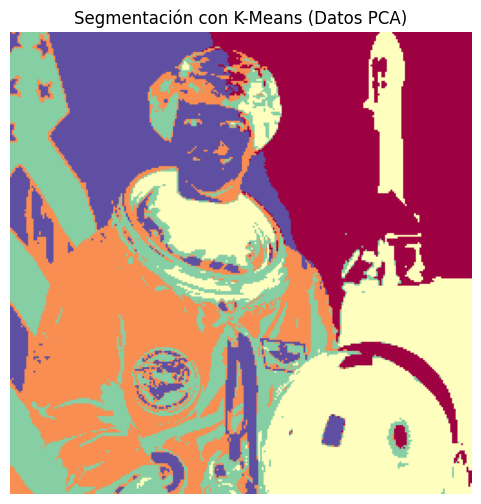

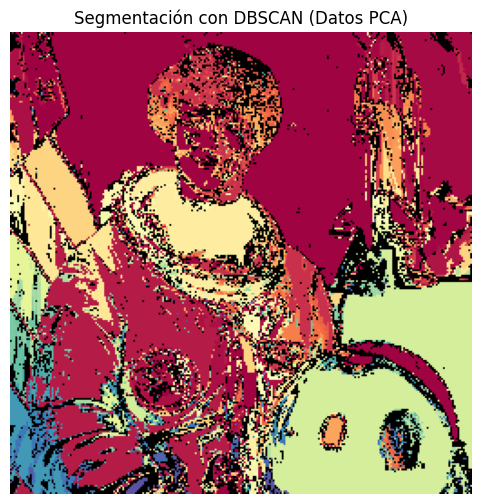

In [55]:

# Reducción de dimensionalidad con PCA
print("Aplicando PCA...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Clustering en datos PCA
labels_kmeans_pca = apply_kmeans_clustering(X_pca)
plot_segmented_image(labels_kmeans_pca, image.shape, 'Segmentación con K-Means (Datos PCA)')

labels_dbscan_pca = apply_dbscan_clustering(X_pca, eps=1.5)
plot_segmented_image(labels_dbscan_pca, image.shape, 'Segmentación con DBSCAN (Datos PCA)')


Aplicando UMAP...


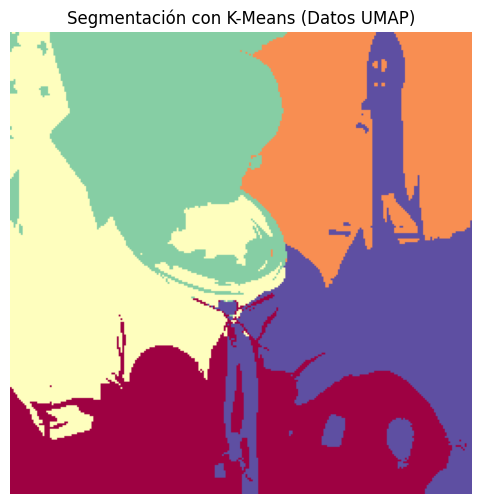

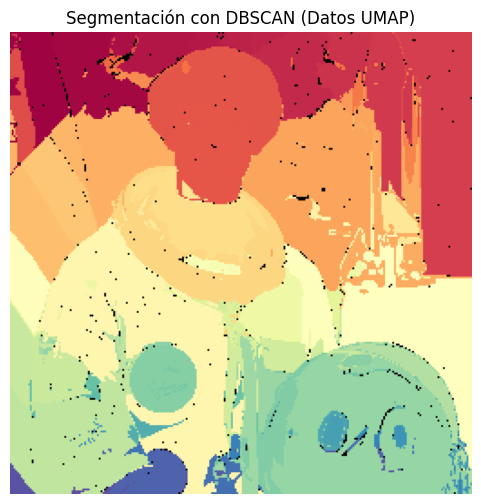

In [60]:

# Reducción de dimensionalidad con UMAP
print("Aplicando UMAP...")
umap_reducer = umap.UMAP(n_components=2)
X_umap = umap_reducer.fit_transform(X)

# Clustering en datos UMAP
labels_kmeans_umap = apply_kmeans_clustering(X_umap)
plot_segmented_image(labels_kmeans_umap, image.shape, 'Segmentación con K-Means (Datos UMAP)')

labels_dbscan_umap = apply_dbscan_clustering(X_umap, eps=0.15)
plot_segmented_image(labels_dbscan_umap, image.shape, 'Segmentación con DBSCAN (Datos UMAP)')